# Random Data Generator
## a. Univariate Gaussian data generator
- mean: $m$
- Variance: $s$
- handcraft gaussian distribution
    - Box-Muller transform v
    - Ziggurat algorithm 
- np.random.uniform()


In [97]:

import numpy as np

def  univariate_Gaussian_data_generator(m,s):
    u1 = np.random.uniform(0,1)
    u2 = np.random.uniform(0,1)
    z = np.sqrt(-2 * np.log(u1)) * np.cos(2 * np.pi * u2)
    x = m + np.sqrt(s) * z
    return x

print(univariate_Gaussian_data_generator(1.2204925277612,0))



1.2204925277612


## b. Polynomial basis linear model data generator 

- $y = W^{T}\phi(x)+e$
- $n$ (basis number)
- $a$ 資料中的雜訊變異數$e$服從一個平均值為0，變異數為$a$的常態分佈  $e \sim N(0,a)$
- $w$ nx1

In [98]:
def polynomial_basis_linear_model_data_generator(n_basis, a, w):
    x = np.random.uniform(-1, 1) # x is uniformly distributed in [-1, 1]
    phi = np.array([x**i for i in range(n_basis)])
    noise = univariate_Gaussian_data_generator(0, a)
    y = np.dot(phi, w) + noise
    return x, y, phi

# print(polynomial_basis_linear_model_data_generator(3, 0.1, [1, 2, 3]))

# Sequential Estimator

In [99]:
m = 3.0
s = 5.0


print("Data point source function: N({},{})".format(m, s))

def sequential_estimator(m,s, max_iter=100, tol=1e-6):
    mean = 0
    variance = 0
    num = 0
    M2 = 0.0
    for i in range(1, max_iter):
        # if num == 0:
        #     x = 1.2204925277612
        # else:
        x = univariate_Gaussian_data_generator(m, s)
        print(f"Add data point: {x:.6f}")
        num += 1
        delta = x - mean
        mean += delta / num
        delta2 = x - mean
        M2 += delta * delta2
        if num > 1:
            variance = M2 / (num - 1)
        else:
            variance = 0.0
        print(f"Mean = {mean:.15f}    Variance = {variance:.15f}\n")
        if num > 10 and abs(mean - m) < tol and abs(variance - s) < tol:
            break
    print(f"Final Mean = {mean:.15f}    Final Variance = {variance:.15f}")

sequential_estimator(m, s, max_iter=1000, tol=1e-6)

Data point source function: N(3.0,5.0)
Add data point: 1.158415
Mean = 1.158415164526469    Variance = 0.000000000000000

Add data point: 6.346910
Mean = 3.752662668048858    Variance = 13.460240219064296

Add data point: 1.566257
Mean = 3.023860903862479    Variance = 8.323576143975684

Add data point: 3.854368
Mean = 3.231487612196271    Variance = 5.721486162704558

Add data point: 8.306543
Mean = 4.246498784695526    Variance = 9.442353023519980

Add data point: 4.250468
Mean = 4.247160266902663    Variance = 7.553885044168245

Add data point: 0.394709
Mean = 3.696810130324787    Variance = 8.415101113292545

Add data point: 3.734046
Mean = 3.701464599184666    Variance = 7.213117124036551

Add data point: 2.134801
Mean = 3.527390879499043    Variance = 6.584192422498681

Add data point: 1.387341
Mean = 3.313385915157836    Variance = 6.310596734292307

Add data point: 3.938771
Mean = 3.370239084276040    Variance = 5.715092172089690

Add data point: 6.854769
Mean = 3.6606165378890

# Bayesian Linear Regression

In [100]:
def predict(x_range, mu, S, n_basis, a):
    means = []
    stds = []
    for x in x_range:
        phi = np.array([x**i for i in range(n_basis)])
        mean = np.dot(mu, phi)
        var = 1/a + np.dot(phi, np.dot(S, phi))
        means.append(mean)
        stds.append(np.sqrt(var))
    return np.array(means), np.array(stds)

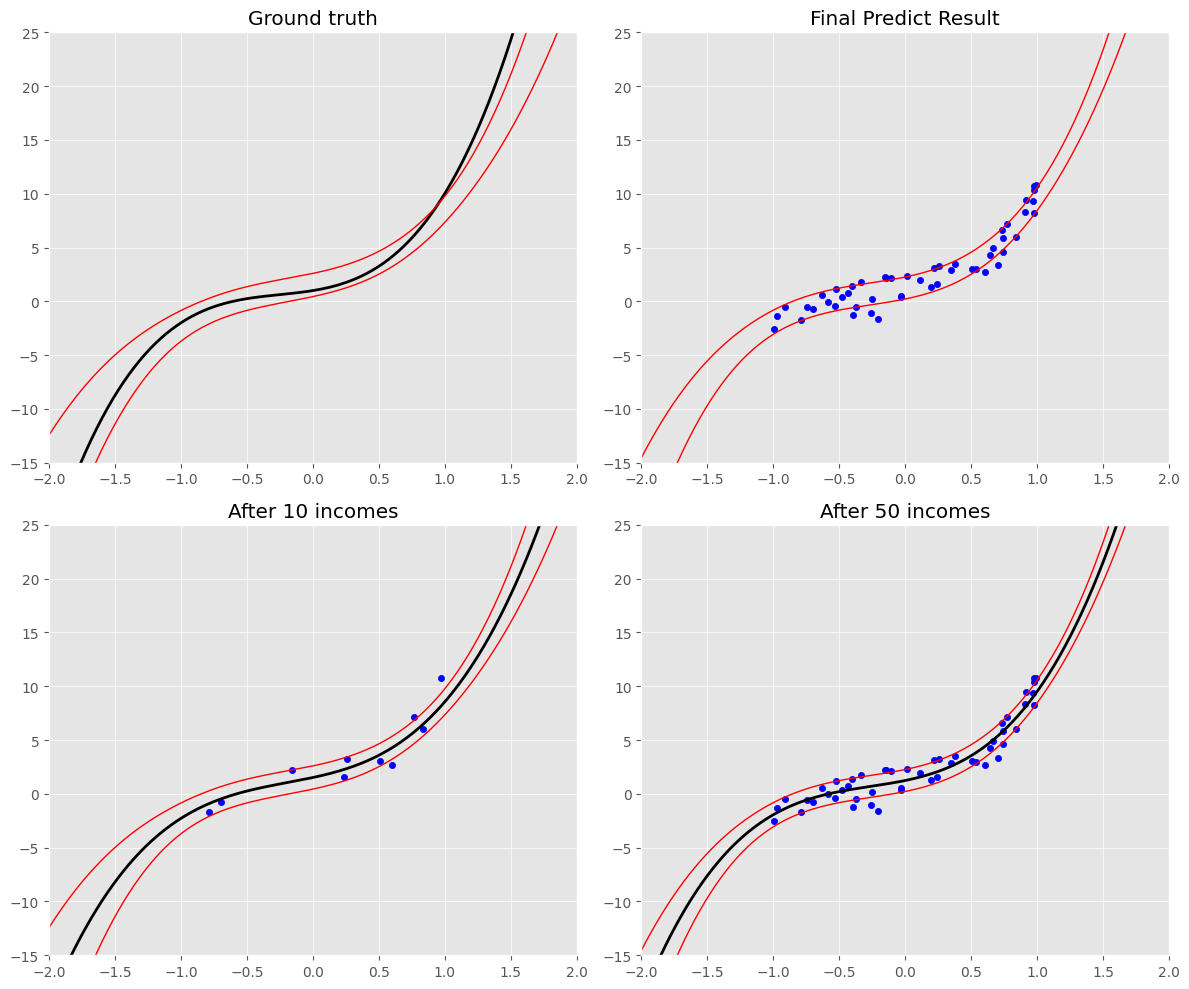

In [ ]:
import matplotlib.pyplot as plt

def bayesian_learning(n_basis, a, w_true, b, steps, temp_steps=[10, 50]):
    S_inv = b * np.identity(n_basis)
    m = np.zeros(n_basis)

    x_seen = []
    y_seen = []

    temp = {}

    for t in range(steps):
        x, y, phi = polynomial_basis_linear_model_data_generator(n_basis, a, w_true)
        S_inv += (1 / a) * np.outer(phi, phi) #每筆資料帶來的資訊
        S = np.linalg.inv(S_inv) # 1
        m += (1 / a) * y * phi # 每筆資料對mean的影響
        mu_post = np.dot(S, m) # 2

        x_seen.append(x)
        y_seen.append(y)

        if (t + 1) in temp_steps:
            temp[t + 1] = {
                "mu": mu_post.copy(),
                "S": S.copy(),
                "x_seen": x_seen.copy(),
                "y_seen": y_seen.copy()
            }

    return temp


def plot_bayes_snapshots(snapshots, n_basis, a, w_true):
    plt.style.use('ggplot')
    x_plot = np.linspace(-2, 2, 200)
    true_y = [np.dot(w_true, [x**i for i in range(n_basis)]) for x in x_plot]

    fig, axs = plt.subplots(2, 2, figsize=(12, 10))

    # 使用第 10 筆 snapshot 資料作為 early prediction baseline
    snap_10 = snapshots[10]
    pred_mean_10, pred_std_10 = predict(x_plot, snap_10["mu"], snap_10["S"], n_basis, a)

    snap_50 = snapshots[50]
    pred_mean_50, pred_std_50 = predict(x_plot, snap_50["mu"], snap_50["S"], n_basis, a)

    # 左上：Ground truth + early prediction band
    axs[0, 0].plot(x_plot, true_y, 'k', label='Ground truth')
    axs[0, 0].plot(x_plot, pred_mean_10 + pred_std_10, 'r', linewidth=1)
    axs[0, 0].plot(x_plot, pred_mean_10 - pred_std_10, 'r', linewidth=1)
    axs[0, 0].set_xlim([-2, 2])
    axs[0, 0].set_ylim([-15, 25])
    axs[0, 0].set_title("Ground truth")
    axs[0, 0].grid(True)

    # 右上：Final predict result
    axs[0, 1].plot(x_plot, pred_mean_50 + pred_std_50, 'r', linewidth=1)
    axs[0, 1].plot(x_plot, pred_mean_50 - pred_std_50, 'r', linewidth=1)
    axs[0, 1].scatter(snap_50["x_seen"], snap_50["y_seen"], color='blue', s=20)
    axs[0, 1].set_xlim([-2, 2])
    axs[0, 1].set_ylim([-15, 25])
    axs[0, 1].set_title("Final Predict Result")
    axs[0, 1].grid(True)

    # 左下：After 10 incomes
    axs[1, 0].plot(x_plot, pred_mean_10, 'black', label='Predict mean')
    axs[1, 0].plot(x_plot, pred_mean_10 + pred_std_10, 'r', linewidth=1)
    axs[1, 0].plot(x_plot, pred_mean_10 - pred_std_10, 'r', linewidth=1)
    axs[1, 0].scatter(snap_10["x_seen"], snap_10["y_seen"], color='blue', s=20)
    axs[1, 0].set_xlim([-2, 2])
    axs[1, 0].set_ylim([-15, 25])
    axs[1, 0].set_title("After 10 incomes")
    axs[1, 0].grid(True)

    # 右下：After 50 incomes
    axs[1, 1].plot(x_plot, pred_mean_50, 'black', label='Predict mean')
    axs[1, 1].plot(x_plot, pred_mean_50 + pred_std_50, 'r', linewidth=1)
    axs[1, 1].plot(x_plot, pred_mean_50 - pred_std_50, 'r', linewidth=1)
    axs[1, 1].scatter(snap_50["x_seen"], snap_50["y_seen"], color='blue', s=20)
    axs[1, 1].set_xlim([-2, 2])
    axs[1, 1].set_ylim([-15, 25])
    axs[1, 1].set_title("After 50 incomes")
    axs[1, 1].grid(True)

    plt.tight_layout()
    plt.show()



temp = bayesian_learning(
    n_basis=4,
    a=1,
    w_true=np.array([1, 2, 3, 4]),
    b=1,
    steps=50

)

plot_bayes_snapshots(temp, n_basis=4, a=1, w_true=np.array([1, 2, 3, 4]))
